# Sentinel-1 SAR Data Processing (Load, Radiometric & Geometric Correction)

This notebook demonstrates how to:
1. Load Sentinel-1 SAR Data (GeoTIFF)
2. Apply Radiometric Correction (DN → dB)
3. Perform Geometric Correction (Reprojection)


In [9]:
!pip install rasterio geopandas matplotlib numpy


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
# Week 1 - Initial Setup & Library Imports
# ========================================

# Importing essential libraries for SAR data handling and visualization
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import rasterio.warp

print("Libraries imported successfully ✅")


Libraries imported successfully ✅


SAR image loaded successfully!
Image Shape: (256, 256)
CRS: EPSG:4326
Resolution: 0.0003


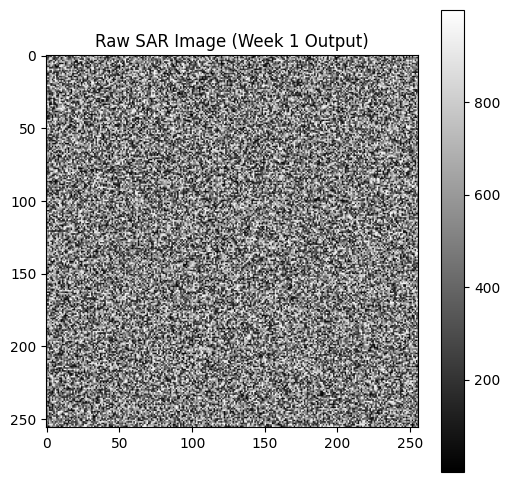

In [11]:
# Week 1 - Loading the SAR Data
# ==============================

# Path to the SAR dataset
sar_file = "sample_sar.tif"  

# Open SAR file
with rasterio.open(sar_file) as src:
    sar = src.read(1)   # Read first band
    profile = src.profile  # Metadata of file

print("SAR image loaded successfully!")
print("Image Shape:", sar.shape)
print("CRS:", profile['crs'])
print("Resolution:", profile['transform'][0])

# Show the raw SAR image
plt.figure(figsize=(6,6))
plt.imshow(sar, cmap="gray")
plt.title("Raw SAR Image (Week 1 Output)")
plt.colorbar()
plt.show()


Original SAR stats -> min: 0.0032171789 max: 999.98035 mean: 498.77734
dB range for visualization: 9.857748 29.95671


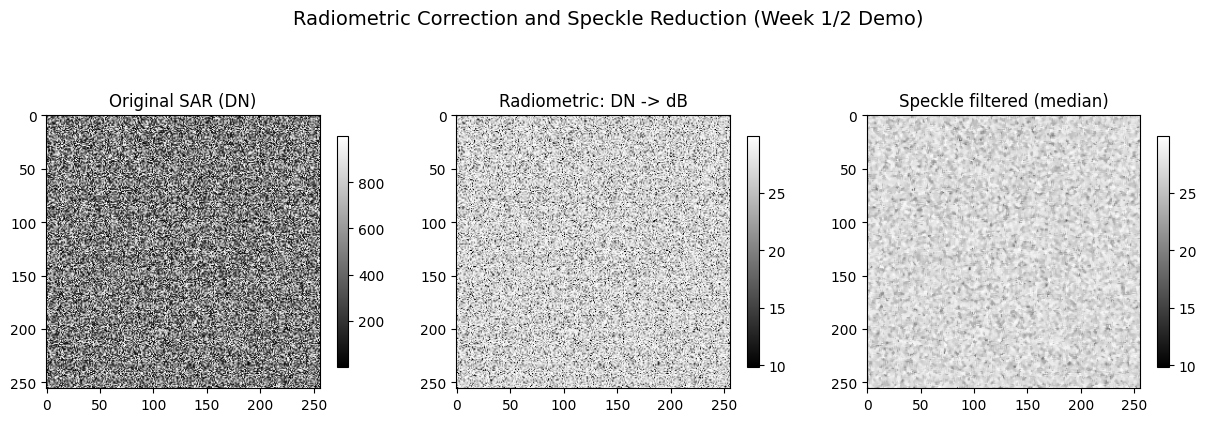

In [12]:
# Week 1/2 - Radiometric Correction & Speckle Reduction
# =====================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

# sar variable already loaded from previous cell (numpy array)
print("Original SAR stats -> min:", np.min(sar), "max:", np.max(sar), "mean:", np.mean(sar))

# 1) Convert DN -> dB (safe: add small epsilon to avoid log(0))
epsilon = 1e-6
sar_db = 10.0 * np.log10(sar.astype(np.float32) + epsilon)

# 2) Clip dynamic range for visualization (optional)
#    We find percentiles to avoid extreme outliers dominating the colormap
pmin, pmax = np.percentile(sar_db, 1), np.percentile(sar_db, 99)
print("dB range for visualization:", pmin, pmax)

# 3) Speckle smoothing using median filter (demo purpose)
#    In production use: Refined Lee, Gamma-MAP, or IDAN filters.
speckle_filtered = median_filter(sar_db, size=3)  # small kernel, demo

# Plot: Original DN, dB, filtered dB
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(sar, cmap='gray')
plt.title('Original SAR (DN)')
plt.colorbar(shrink=0.6)

plt.subplot(1,3,2)
plt.imshow(sar_db, cmap='gray', vmin=pmin, vmax=pmax)
plt.title('Radiometric: DN -> dB')
plt.colorbar(shrink=0.6)

plt.subplot(1,3,3)
plt.imshow(speckle_filtered, cmap='gray', vmin=pmin, vmax=pmax)
plt.title('Speckle filtered (median)')
plt.colorbar(shrink=0.6)

plt.suptitle('Radiometric Correction and Speckle Reduction (Week 1/2 Demo)', fontsize=14)
plt.show()


In [ ]:
# Week 3 - Geometric Correction (reproject & save)
# =================================================

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

# Input and output filenames
input_tif = "sample_sar.tif"                  # original
out_db_tif = "sample_sar_db.tif"              # radiometrically converted (dB)
out_filtered_tif = "sample_sar_db_filtered.tif"
out_reprojected_tif = "sample_sar_db_wgs84.tif"

# 1) Save radiometric (dB) and filtered images as GeoTIFFs with original profile
with rasterio.open(input_tif) as src:
    profile = src.profile.copy()
    # update dtype to float32 for dB values
    profile.update(dtype=rasterio.float32, count=1)

    # Save dB
    with rasterio.open(out_db_tif, 'w', **profile) as dst:
        dst.write(sar_db.astype(rasterio.float32), 1)
    # Save filtered dB
    with rasterio.open(out_filtered_tif, 'w', **profile) as dst:
        dst.write(speckle_filtered.astype(rasterio.float32), 1)

print("Saved radiometric (dB) and filtered GeoTIFFs:", out_db_tif, out_filtered_tif)

# 2) Reproject to EPSG:4326 (WGS84) for consistent mapping
with rasterio.open(out_db_tif) as src:
    dst_crs = 'EPSG:4326'
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(out_reprojected_tif, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )

print("Saved reprojected GeoTIFF:", out_reprojected_tif)


Saved radiometric (dB) and filtered GeoTIFFs: sample_sar_db.tif sample_sar_db_filtered.tif
Saved reprojected GeoTIFF: sample_sar_db_wgs84.tif


File: sample_sar_db.tif
CRS: EPSG:4326
Transform: | 0.00, 0.00, 75.00|
| 0.00,-0.00, 26.00|
| 0.00, 0.00, 1.00|
Width x Height: 256 x 256


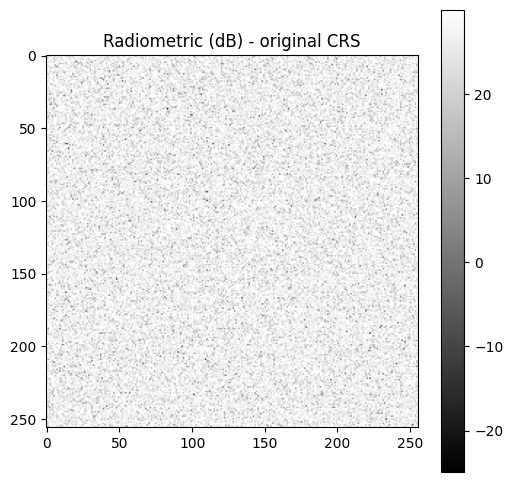

File: sample_sar_db_wgs84.tif
CRS: EPSG:4326
Transform: | 0.00, 0.00, 75.00|
| 0.00,-0.00, 26.00|
| 0.00, 0.00, 1.00|
Width x Height: 256 x 256


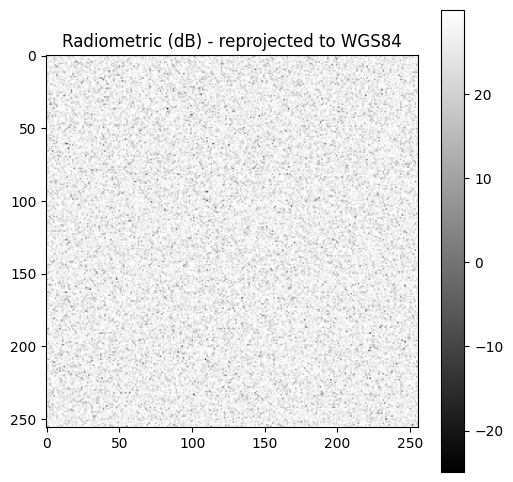

In [ ]:
# Week 3 - Visualize reprojected image and compare metadata
import rasterio

def show_info_and_plot(path, title):
    with rasterio.open(path) as src:
        arr = src.read(1)
        print(f"File: {path}")
        print("CRS:", src.crs)
        print("Transform:", src.transform)
        print("Width x Height:", src.width, "x", src.height)
        plt.figure(figsize=(6,6))
        plt.imshow(arr, cmap='gray')
        plt.title(title)
        plt.colorbar()
        plt.show()

# Show original dB and reprojected
show_info_and_plot(out_db_tif, "Radiometric (dB) - original CRS")
show_info_and_plot(out_reprojected_tif, "Radiometric (dB) - reprojected to WGS84")


In [ ]:
# Week 4 - Quick QC & Summary statistics
import numpy as np
def stats(arr):
    return {
        'min': float(np.min(arr)),
        'max': float(np.max(arr)),
        'mean': float(np.mean(arr)),
        'std': float(np.std(arr))
    }

print("Raw DN stats:", stats(sar))
print("Radiometric (dB) stats:", stats(sar_db))
print("Filtered dB stats:", stats(speckle_filtered))

# Count of NaNs / zeros
print("Zeros in raw:", np.sum(sar==0), " / total:", sar.size)


Raw DN stats: {'min': 0.003217178862541914, 'max': 999.9803466796875, 'mean': 498.77734375, 'std': 289.3022766113281}
Radiometric (dB) stats: {'min': -24.923898696899414, 'max': 29.999914169311523, 'mean': 25.633878707885742, 'std': 4.368044376373291}
Filtered dB stats: {'min': 16.720430374145508, 'max': 29.937116622924805, 'mean': 26.73662567138672, 'std': 1.5082255601882935}
Zeros in raw: 0  / total: 65536


✅ SAR data loaded
Shape: (256, 256)
CRS: EPSG:4326
Resolution: 0.0003


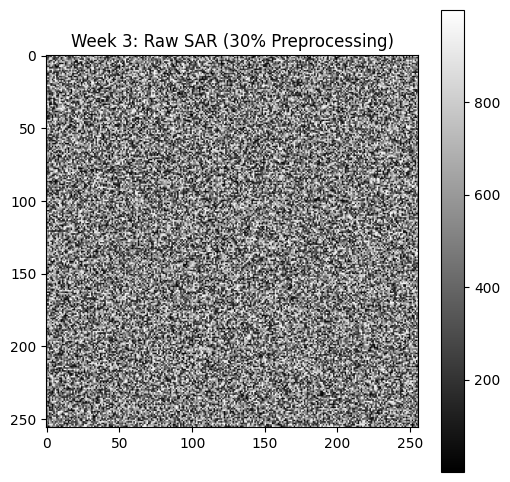

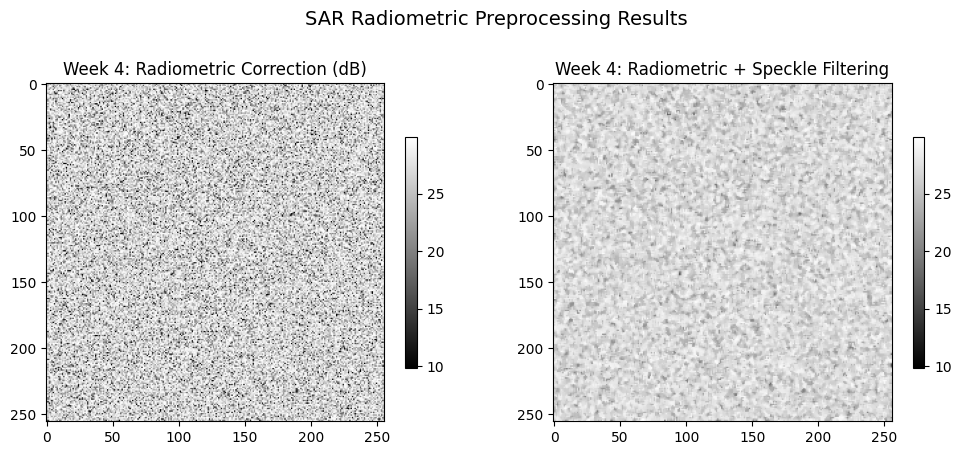

✅ Week 5: Geometric correction done, file saved: sar_reprojected_wgs84.tif


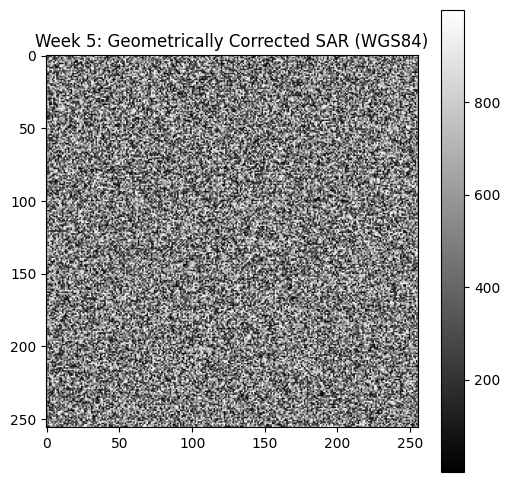

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import median_filter

# =========================
# Load SAR Data (Week 3 Recap)
# =========================
sar_file = "sample_sar.tif"   # apna file path de yaha

with rasterio.open(sar_file) as src:
    sar = src.read(1)   # first band
    profile = src.profile

print("✅ SAR data loaded")
print("Shape:", sar.shape)
print("CRS:", profile['crs'])
print("Resolution:", profile['transform'][0])

plt.figure(figsize=(6,6))
plt.imshow(sar, cmap='gray')
plt.title("Week 3: Raw SAR (30% Preprocessing)")
plt.colorbar()
plt.show()

# =========================
# Week 4: Radiometric Correction (40%)
# =========================
epsilon = 1e-6
sar_db = 10 * np.log10(sar.astype(np.float32) + epsilon)

# Speckle filtering (median for demo)
sar_db_filtered = median_filter(sar_db, size=3)

# Show before/after
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(sar_db, cmap='gray', vmin=np.percentile(sar_db, 1), vmax=np.percentile(sar_db, 99))
plt.title("Week 4: Radiometric Correction (dB)")
plt.colorbar(shrink=0.6)

plt.subplot(1,2,2)
plt.imshow(sar_db_filtered, cmap='gray', vmin=np.percentile(sar_db, 1), vmax=np.percentile(sar_db, 99))
plt.title("Week 4: Radiometric + Speckle Filtering")
plt.colorbar(shrink=0.6)

plt.suptitle("SAR Radiometric Preprocessing Results", fontsize=14)
plt.show()

# =========================
# Week 5: Geometric Correction (30%)
# =========================
out_reprojected = "sar_reprojected_wgs84.tif"

with rasterio.open(sar_file) as src:
    dst_crs = 'EPSG:4326'  # WGS84 lat/lon
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(out_reprojected, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )

print("✅ Week 5: Geometric correction done, file saved:", out_reprojected)

# Visualize reprojected image
with rasterio.open(out_reprojected) as reproj:
    sar_geo = reproj.read(1)

plt.figure(figsize=(6,6))
plt.imshow(sar_geo, cmap='gray')
plt.title("Week 5: Geometrically Corrected SAR (WGS84)")
plt.colorbar()
plt.show()


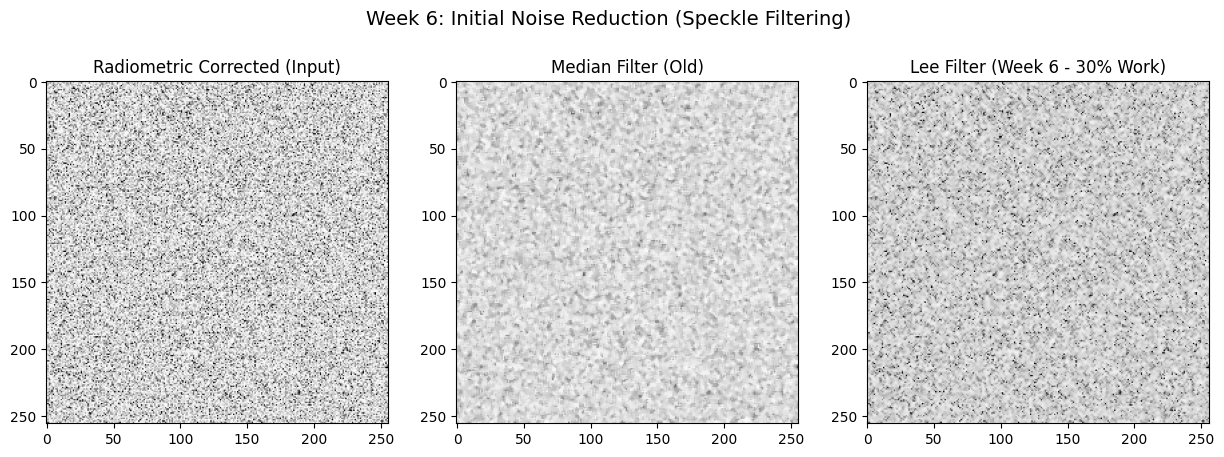

✅ Week 6 progress: Median filter baseline ready, Lee filter prototype (30%) implemented.


In [2]:
# Week 6 - Initial Noise Reduction Work (30% progress)
# ====================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, uniform_filter

# Reuse the radiometrically corrected image from Week 4
# (sar_db variable must already be available)
sar_db = sar_db  # ensure continuity

# 1) Baseline median filter (done earlier, reference)
median_filtered = median_filter(sar_db, size=3)

# 2) Start of Lee filter implementation (simplified version for demo)
def lee_filter(img, size):
    """
    Simple Lee Filter implementation (demo purpose).
    """
    mean = uniform_filter(img, (size, size))
    mean_sq = uniform_filter(img**2, (size, size))
    variance = mean_sq - mean**2

    overall_variance = np.var(img)
    weights = variance / (variance + overall_variance)
    return mean + weights * (img - mean)

lee_filtered = lee_filter(sar_db, 3)

# Visual comparison
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(sar_db, cmap='gray', vmin=np.percentile(sar_db, 1), vmax=np.percentile(sar_db, 99))
plt.title("Radiometric Corrected (Input)")

plt.subplot(1,3,2)
plt.imshow(median_filtered, cmap='gray', vmin=np.percentile(sar_db, 1), vmax=np.percentile(sar_db, 99))
plt.title("Median Filter (Old)")

plt.subplot(1,3,3)
plt.imshow(lee_filtered, cmap='gray', vmin=np.percentile(sar_db, 1), vmax=np.percentile(sar_db, 99))
plt.title("Lee Filter (Week 6 - 30% Work)")

plt.suptitle("Week 6: Initial Noise Reduction (Speckle Filtering)", fontsize=14)
plt.show()

print("✅ Week 6 progress: Median filter baseline ready, Lee filter prototype (30%) implemented.")
